# Machine Learning in Python - Project 2

Due Friday, Apr 11th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [142]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import shap
from scipy.stats import skew

In [143]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv", dtype={
    'cd_msa': str,
    'zipcode': str,
    'id_loan_rr': str, 
    'rr_ind':str})
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
0,809,201705,N,204704,NaN,0,1,P,75,38,...,Other sellers,SPECIALIZED LOAN SERVICING LLC,NaN,NaN,9,NaN,2,N,7,prepaid
1,702,201703,N,203202,NaN,0,1,P,80,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,active
2,792,201703,N,204702,NaN,0,1,S,60,36,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
3,776,201703,N,204702,NaN,0,1,S,80,18,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
4,790,201703,N,204702,41620,0,1,I,75,42,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. Freddie Mac).*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft and the appropriate type of plot and summary for each variable type - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also motivate and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Pipelines should be used and feature engineering steps that are be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 1. Get general info

In [144]:
# For general info 
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fico            200000 non-null  int64  
 1   dt_first_pi     200000 non-null  int64  
 2   flag_fthb       200000 non-null  object 
 3   dt_matr         200000 non-null  int64  
 4   cd_msa          181072 non-null  object 
 5   mi_pct          200000 non-null  int64  
 6   cnt_units       200000 non-null  int64  
 7   occpy_sts       200000 non-null  object 
 8   cltv            200000 non-null  int64  
 9   dti             200000 non-null  int64  
 10  orig_upb        200000 non-null  int64  
 11  ltv             200000 non-null  int64  
 12  int_rt          200000 non-null  float64
 13  channel         200000 non-null  object 
 14  ppmt_pnlty      200000 non-null  object 
 15  prod_type       200000 non-null  object 
 16  st              200000 non-null  object 
 17  prop_type 

## 2. Filter Active Loans and Check Target Distribution

In [145]:
# Filter out active loans (only keep 'default' and 'prepaid')
d_filtered = d[d['loan_status'].isin(['default', 'prepaid'])].copy()
d_filtered['loan_status'] = d_filtered['loan_status'].map({'default': 1, 'prepaid': 0})
print("Data shape after filtering active loans:", d_filtered.shape)

# Check target distribution
target_dist = d_filtered['loan_status'].value_counts(normalize=True) * 100
print("\nTarget Distribution (%):")
print(target_dist)

Data shape after filtering active loans: (126705, 33)

Target Distribution (%):
loan_status
0    99.411231
1     0.588769
Name: proportion, dtype: float64


## 3. Find Missing Values and Drop Useless Features

In [146]:
# Replace missing values with NaN
missing_values = {
    'fico': [9999],
    'flag_fthb': ['9'],
    'mi_pct': [999],
    'cnt_units': [99],
    'occpy_sts': ['9'],
    'cltv': [999],
    'dti': [999],
    'ltv': [999],
    'channel': ['9'],
    'prop_type': ['99'],
    'loan_purpose': ['9'],
    'program_ind': ['9'],
    'property_val': [9],
    'mi_cancel_ind': ['7', '9'],
    'flag_sc': ['N'],
    'rr_ind': ['N'],
}

for col, codes in missing_values.items():
    d_filtered[col] = d_filtered[col].replace(codes, np.nan)

missing_values = d_filtered.isna().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(d_filtered)) * 100
print("Missing Values in Training Data:")
print(pd.DataFrame({'Missing Count': missing_values, 'Percentage (%)': missing_percent})
      [missing_values > 0])


Missing Values in Training Data:
               Missing Count  Percentage (%)
id_loan_rr            125406       98.974784
rr_ind                125406       98.974784
flag_sc               121241       95.687621
program_ind           116496       91.942702
mi_cancel_ind          87026       68.683951
cd_msa                 11294        8.913618
dti                     1304        1.029162
property_val              94        0.074188
fico                      24        0.018942
ltv                        1        0.000789
mi_pct                     1        0.000789
cltv                       1        0.000789


In [147]:
missing_pct = d_filtered.isna().mean()
high_missing_cols = missing_pct[missing_pct > 0.9].index.tolist()
print("Columns with >90% missing values:", high_missing_cols)

# Check for columns with all same non-NaN values
constant_cols = []
for col in d_filtered.columns:
    if d_filtered[col].nunique(dropna=True) == 1:
        constant_cols.append(col)

print("Columns with constant values:", constant_cols)

ide_cols = ['id_loan', 'seller_name', 'servicer_name']

cols_to_drop = list(set(constant_cols + high_missing_cols + ide_cols))
print("Columns to drop:", cols_to_drop)

d_filtered = d_filtered.drop(columns=cols_to_drop, errors='ignore')

Columns with >90% missing values: ['flag_sc', 'id_loan_rr', 'program_ind', 'rr_ind']
Columns with constant values: ['ppmt_pnlty', 'prod_type', 'flag_sc', 'rr_ind', 'io_ind']
Columns to drop: ['prod_type', 'ppmt_pnlty', 'servicer_name', 'id_loan', 'flag_sc', 'io_ind', 'seller_name', 'program_ind', 'rr_ind', 'id_loan_rr']


## 4. Train-Test Split

In [148]:
# Split data before EDA to avoid data leakage
X = d_filtered.drop('loan_status', axis=1)
y = d_filtered['loan_status']

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

In [149]:
# Example for numeric columns
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv']
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])


ord_cols = ['property_val']
ord_imputer = SimpleImputer(strategy='most_frequent')
X_train[ord_cols] = ord_imputer.fit_transform(X_train[ord_cols])
X_test[ord_cols] = ord_imputer.transform(X_test[ord_cols])


# Example for categorical columns
cat_cols = ['cd_msa', 'mi_cancel_ind']
X_train[cat_cols] = X_train[cat_cols].fillna('Unknown')
X_test[cat_cols] = X_test[cat_cols].fillna('Unknown')


## 5. Feature Engineering

In [150]:

# Convert date columns to datetime and calculate loan term
X_train['dt_first_pi'] = pd.to_datetime(X_train['dt_first_pi'], format='%Y%m')
X_train['dt_matr'] = pd.to_datetime(X_train['dt_matr'], format='%Y%m')
X_train['loan_age_months'] = (X_train['dt_matr'] - X_train['dt_first_pi']).dt.days // 30

# Repeat for test data
X_test['dt_first_pi'] = pd.to_datetime(X_test['dt_first_pi'], format='%Y%m')
X_test['dt_matr'] = pd.to_datetime(X_test['dt_matr'], format='%Y%m')
X_test['loan_age_months'] = (X_test['dt_matr'] - X_test['dt_first_pi']).dt.days // 30

# Drop original date columns
X_train = X_train.drop(columns=['dt_first_pi', 'dt_matr'])
X_test = X_test.drop(columns=['dt_first_pi', 'dt_matr'])

# Combine training data for EDA
train_df = pd.concat([X_train, y_train], axis=1)
print("\nTraining data shape:", train_df.shape)



Training data shape: (101364, 22)


## 5. Exploratory Data Analysis (EDA)

### 5.1 Numerical Features Analysis

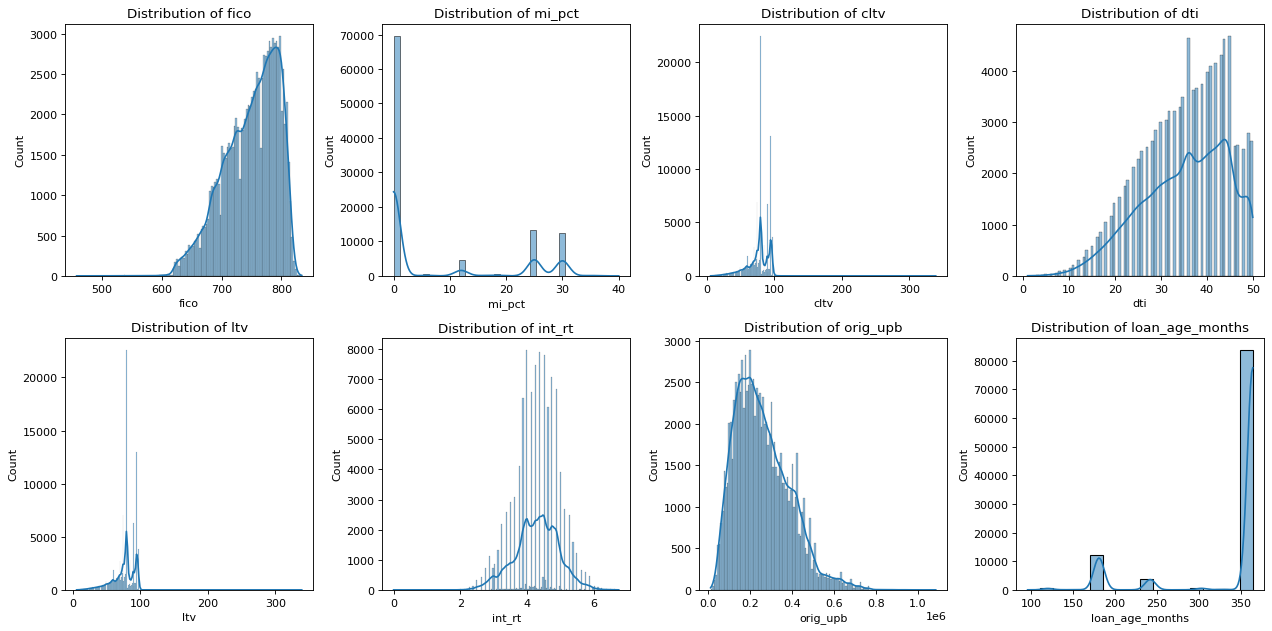

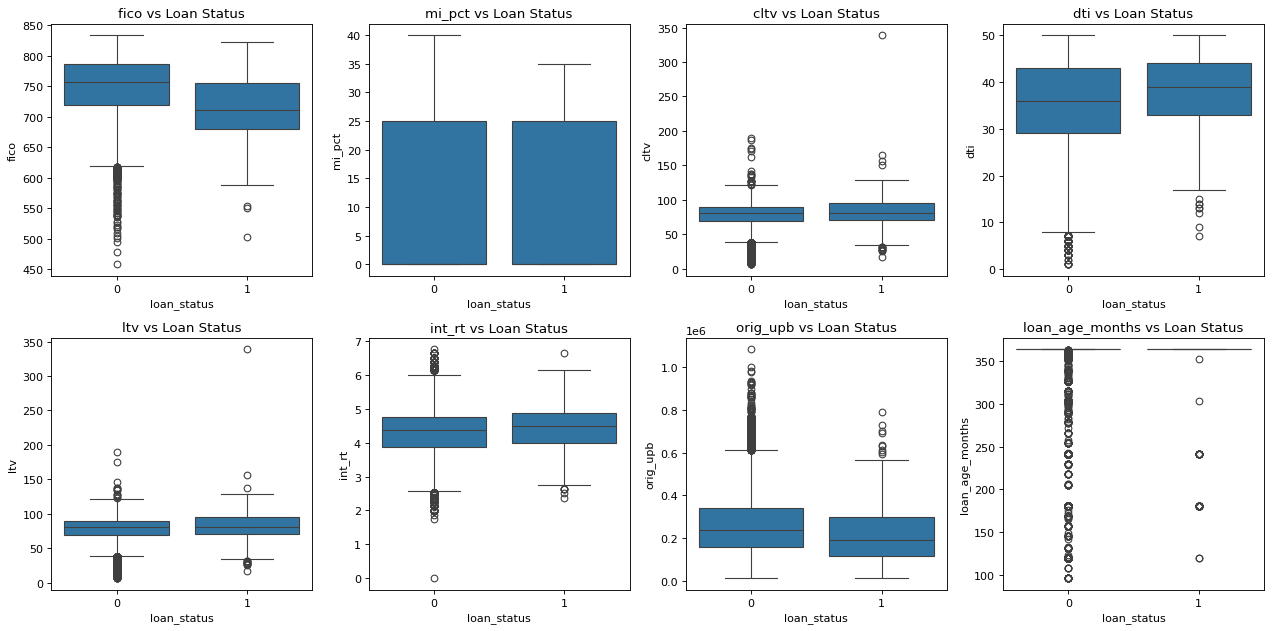

In [151]:
num_cols = ['fico', 'mi_pct', 'cltv', 'dti', 'ltv', 'int_rt', 'orig_upb', 'loan_age_months']

# Distributions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(num_cols):
    sns.histplot(train_df[col], ax=axes[i//4, i%4], kde=True)
    axes[i//4, i%4].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


# Relationships with Target
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, col in enumerate(num_cols):
    sns.boxplot(x='loan_status', y=col, data=train_df, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'{col} vs Loan Status')
plt.tight_layout()
plt.show()

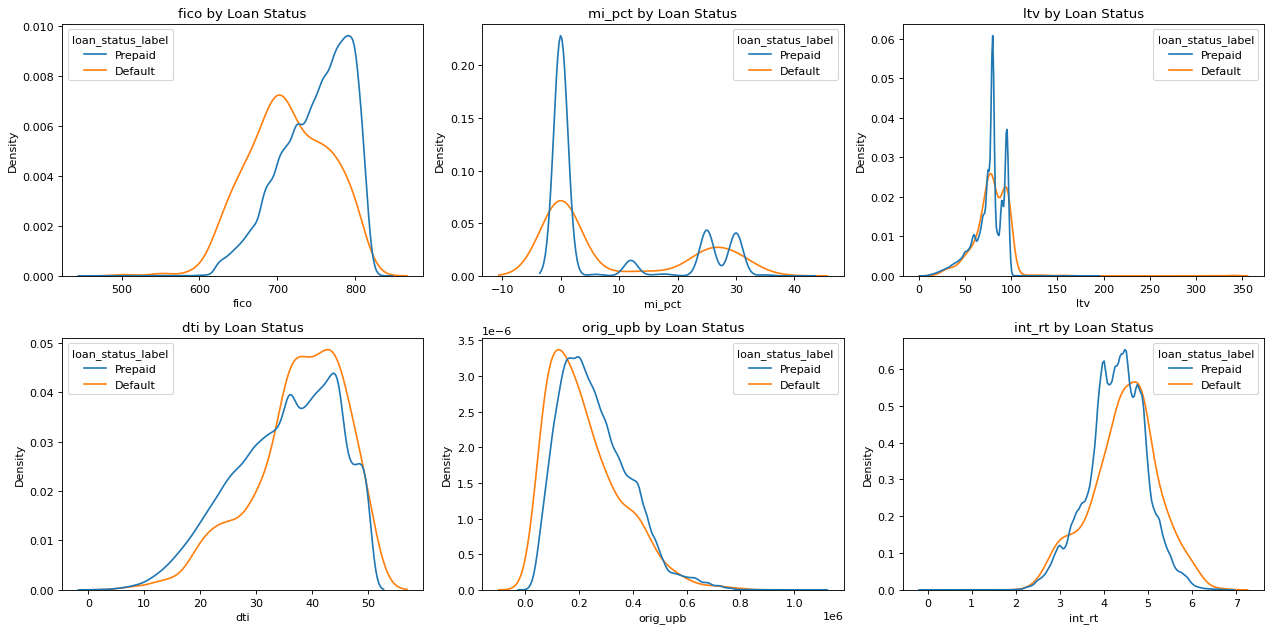

In [152]:
# Numerical feature distribution comparison by loan status
num_vars = ['fico', 'mi_pct', 'ltv', 'dti', 'orig_upb', 'int_rt']
train_df['loan_status_label'] = train_df['loan_status'].map({0: 'Prepaid', 1: 'Default'})

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    if col in train_df.columns:
        sns.kdeplot(data=train_df, x=col, hue='loan_status_label', ax=axes[i], common_norm=False)
        axes[i].set_title(f'{col} by Loan Status')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')

# Remove extra subplot if num_vars < total subplots
for j in range(len(num_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 5.2 Categorical Features Analysis

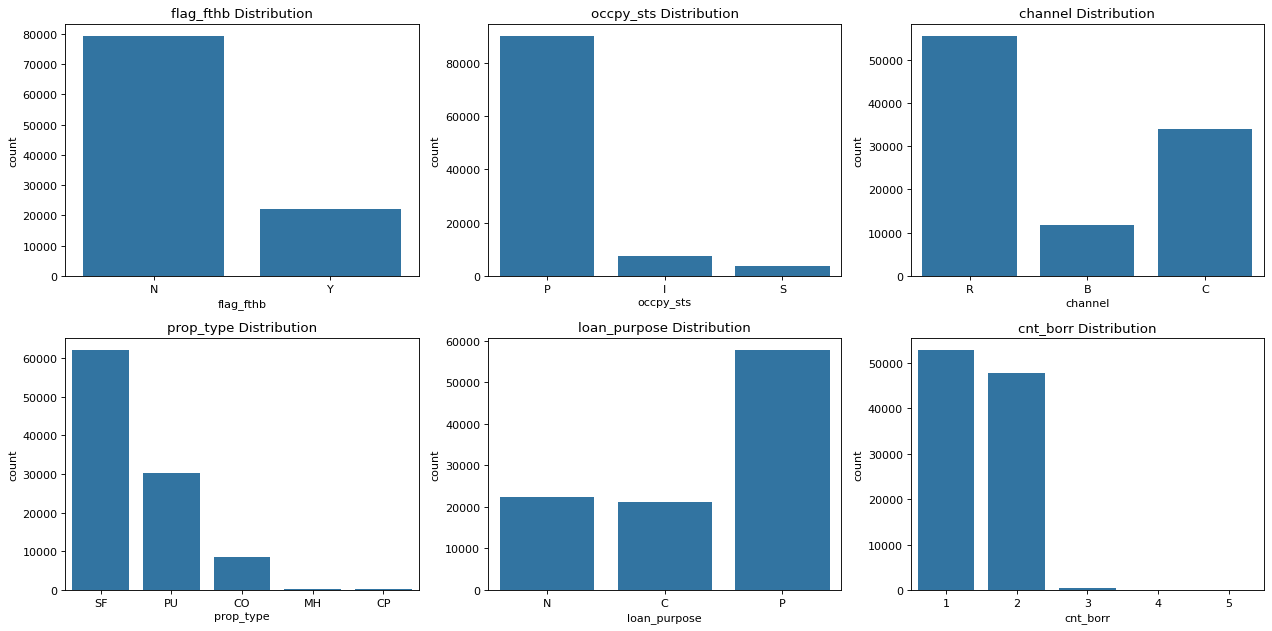

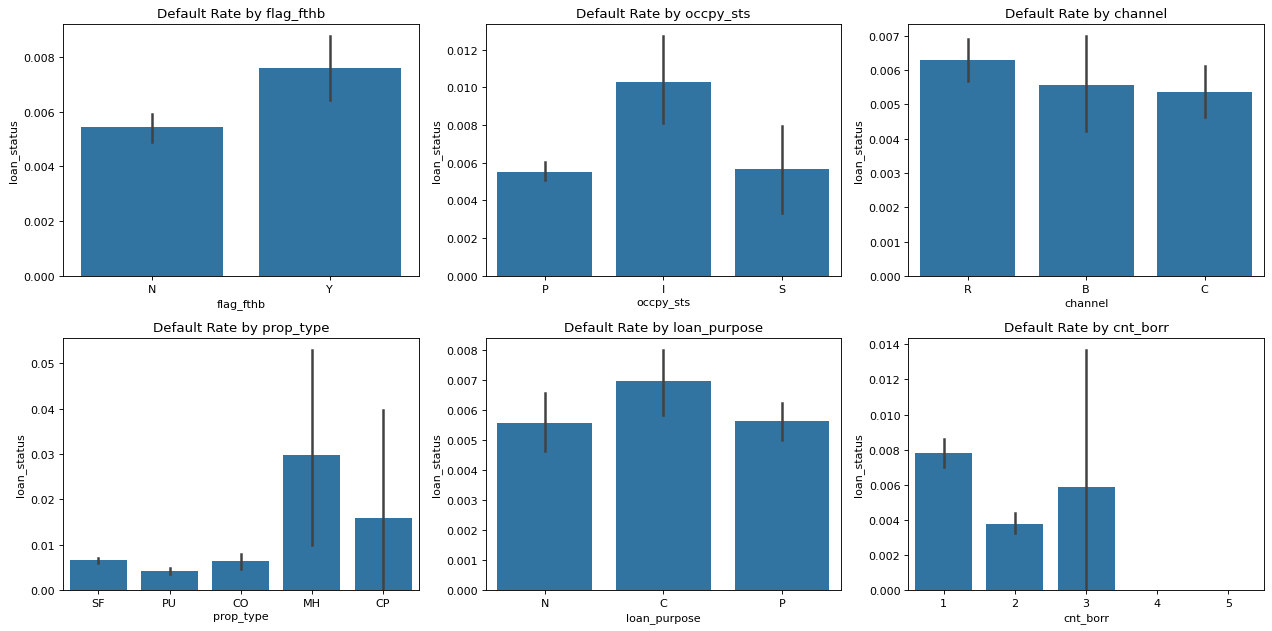

In [153]:
cat_cols = ['flag_fthb', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 'cnt_borr']

# Frequency plots
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=train_df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'{col} Distribution')
    axes[i//3, i%3].tick_params(axis='x')
plt.tight_layout()
plt.show()

# Relationship with Target
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for i, col in enumerate(cat_cols):
    sns.barplot(x=col, y='loan_status', data=train_df, ax=axes[i//3, i%3], estimator=np.mean)
    axes[i//3, i%3].set_title(f'Default Rate by {col}')
    axes[i//3, i%3].tick_params(axis='x')
plt.tight_layout()
plt.show()


### 5.3 Correlation Analysis

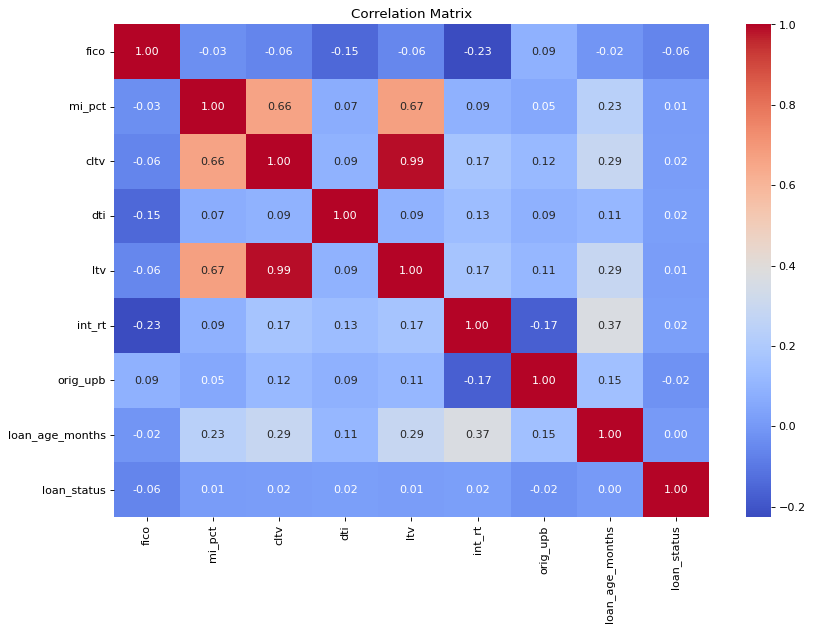

In [154]:
corr_matrix = train_df[num_cols + ['loan_status']].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Dropping CLTV instead of LTV is a deliberate choice based on domain relevance and model interpretability. Here's the detailed reasoning:

1. Business Context: LTV vs. CLTV
LTV (Loan-to-Value Ratio):
Measures the primary mortgage amount relative to the property value.
Example: A 
200
k
m
o
r
t
g
a
g
e
o
n
a
200kmortgageona250k home → LTV = 80%.

Industry Standard: LTV is the most widely used metric in mortgage underwriting and default prediction.

Regulatory Focus: Agencies like FHFA and Freddie Mac prioritize LTV in risk assessments.

CLTV (Combined Loan-to-Value Ratio):
Includes all liens on the property (e.g., second mortgages, HELOCs).
Example: A 
200
k
f
i
r
s
t
m
o
r
t
g
a
g
e
+
200kfirstmortgage+50k HELOC on a $250k home → CLTV = 100%.

Redundancy: In your dataset, CLTV and LTV are nearly identical (r=0.99), meaning most loans likely have no secondary liens.

2. Statistical Reasons to Drop CLTV
Multicollinearity:
High correlation between CLTV and LTV can destabilize linear models (e.g., logistic regression) by inflating coefficient variances.

Feature Importance:
In tree-based models (e.g., XGBoost), both features will compete for splits, diluting their individual importance.

Simpler Model:
Dropping CLTV reduces dimensionality without losing predictive power (since LTV captures nearly the same information).

3. Practical Considerations
Interpretability:
LTV is more intuitive for stakeholders (e.g., "A 90% LTV loan is riskier than 80%").

Data Quality:
If CLTV has more missing values or inconsistencies (common in datasets where secondary liens are rare), retaining LTV is safer.

In [155]:
X_train = X_train.drop(columns=['cltv'])
X_test = X_test.drop(columns=['cltv'])

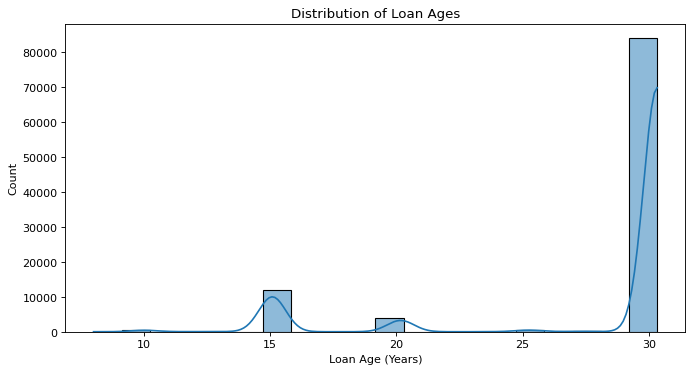

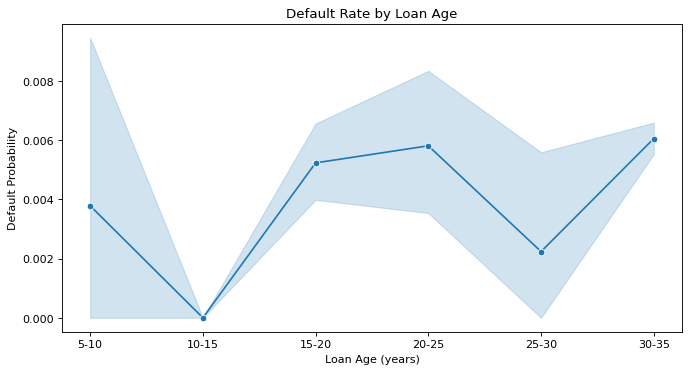

In [156]:
# Example: Custom bins based on observed data
train_df['loan_age_years'] = train_df['loan_age_months'] / 12
max_age = train_df['loan_age_years'].max()
bins = np.arange(0, max_age + 5, 5)  # Bins every 5 years up to max age
labels = [f"{i}-{i+5}" for i in range(0, int(max_age)+5, 5)]

train_df['loan_age_bin'] = pd.cut(
    train_df['loan_age_years'],
    bins=bins,
    labels=labels
)
plt.figure(figsize=(10,5))
sns.histplot(train_df['loan_age_years'], bins=20, kde=True)
plt.title('Distribution of Loan Ages')
plt.xlabel('Loan Age (Years)')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='loan_age_bin', y='loan_status', data=train_df, 
             estimator=np.mean, marker='o')
plt.title('Default Rate by Loan Age')
plt.ylabel('Default Probability')
plt.xlabel('Loan Age (years)')
plt.show()

fico skew: -0.65
orig_upb skew: 0.78
fico_log skew: -0.39
orig_upb_log skew: -0.52


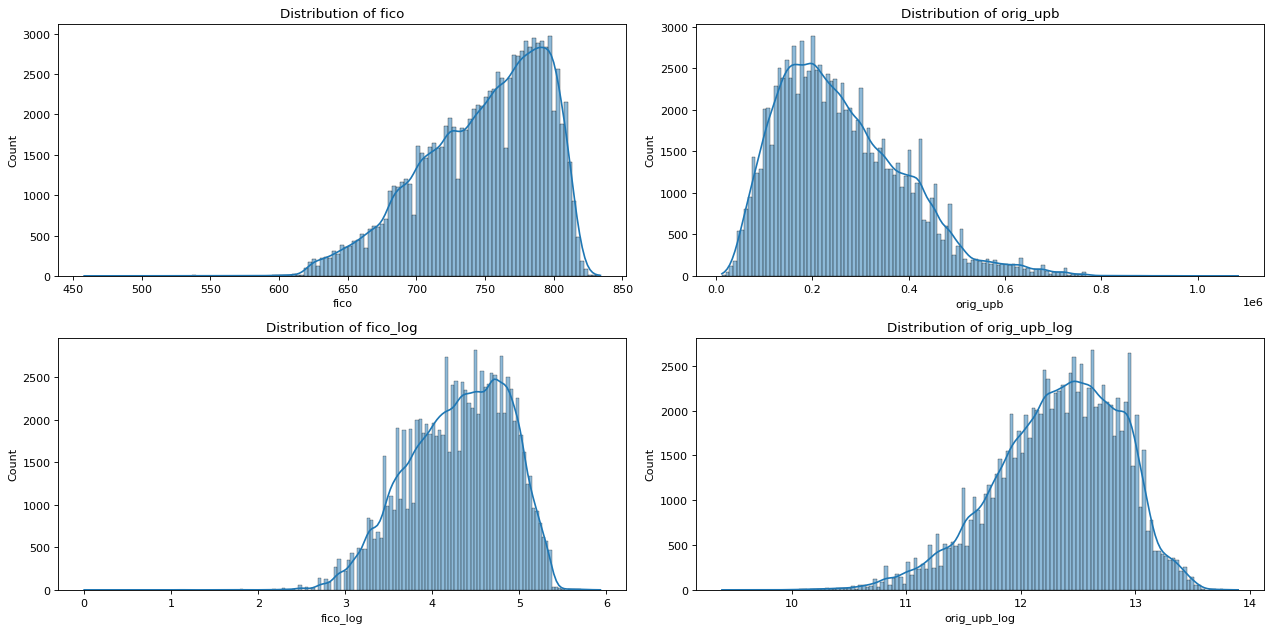

In [157]:
# Log-transform 'orig_upb' (add 1 to avoid log(0))
X_train['orig_upb_log'] = np.log1p(X_train['orig_upb'])
X_test['orig_upb_log'] = np.log1p(X_test['orig_upb'])

X_train['fico_log'] = np.log1p(X_train['fico'].max() - X_train['fico'])
X_test['fico_log'] = np.log1p(X_test['fico'].max() - X_test['fico'])

skewed_cols = ['fico', 'orig_upb', 'fico_log', 'orig_upb_log']
for col in skewed_cols:
    print(f"{col} skew: {skew(X_train[col]):.2f}")

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i, col in enumerate(skewed_cols):
    sns.histplot(X_train[col], ax=axes[i//2, i%2], kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

### 5.4 Feature Engineering Insights

In [158]:
# Create loan-to-income ratio
train_df['lti'] = train_df['orig_upb'] / (train_df['dti'] * 1000)  # Assuming dti is ratio

# ### 5.7 Key Findings Documentation
print("Key EDA Findings:")
print("- Severe class imbalance: Only", round(target_dist[1],1), "% defaults")
print("- FICO scores show clear separation between classes (lower for defaults)")
print("- High correlation between CLTV and LTV (r =", round(corr_matrix.loc['cltv','ltv'],2), ")")
print("- Default rate doubles for investment properties vs primary residences")


Key EDA Findings:
- Severe class imbalance: Only 0.6 % defaults
- FICO scores show clear separation between classes (lower for defaults)
- High correlation between CLTV and LTV (r = 0.99 )
- Default rate doubles for investment properties vs primary residences


# Model Fitting and Tuning

*In this section you should detail and motivate your choice of model and describe the process used to refine, tune, and fit that model. You are encouraged to explore different models but you should NOT include a detailed narrative or code of all of these attempts. At most this section should briefly mention the methods explored and why they were rejected - most of your effort should go into describing the final model you are using and your process for tuning and validating it.*

*This section should include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide a comparison of your model with a baseline model of your choice on the test data but only briefly describe the baseline model considered.*

## Baseline model

We selected Logistic Regression as the baseline due to its interpretability, speed, and ability to handle imbalanced classes when using class weighting. While more complex models may outperform it, Logistic Regression provides a strong, explainable benchmark.

Here’s why certain features were excluded from the baseline model, despite 20 being available after EDA:

1. High Cardinality or Sparsity
Features: cd_msa (MSA codes), zipcode, st (state), mi_cancel_ind

Reason:

cd_msa and zipcode have thousands of unique values. Encoding them as one-hot features would create high-dimensional, sparse data (e.g., 50+ dummy variables for states), increasing model complexity without clear benefits for a baseline.

mi_cancel_ind (mortgage insurance cancellation) had many missing or "Not Applicable" values after preprocessing, reducing its reliability.

2. Redundancy
Feature: orig_loan_term (original loan term in months)

Reason:

The loan term is already indirectly captured by loan_age_months (age of the loan) and dt_first_pi/dt_matr (dates). Including both could introduce multicollinearity without adding unique predictive power.

3. Risk of Data Leakage
Feature: property_val (property appraisal method)

Reason:

This variable might reflect post-origination actions (e.g., a property reappraisal after default). Using it could leak future information not available at loan origination, violating the model’s real-world applicability.

4. Low Interpretability or Relevance
Features: cnt_units (number of units), cnt_borr (number of borrowers)

Reason:

cnt_units (e.g., 1-unit vs. 4-unit properties) showed minimal correlation with default rates in EDA.

cnt_borr (number of borrowers) was excluded because it had low variance (e.g., 95% of loans had 1–2 borrowers).

5. Baseline Model Philosophy
The baseline model prioritizes simplicity and interpretability over maximal predictive power. Including all 20 features would:

Complicate the model with marginal or noisy features (e.g., st, zipcode).

Reduce transparency, making it harder to explain coefficients to stakeholders.

Increase computational cost without guaranteeing better performance.

              precision    recall  f1-score   support

           0       1.00      0.67      0.80     25192
           1       0.01      0.65      0.02       149

    accuracy                           0.67     25341
   macro avg       0.50      0.66      0.41     25341
weighted avg       0.99      0.67      0.80     25341

Baseline Model Performance:
- Accuracy: 0.67
- Precision: 0.01
- Recall: 0.65
- F1 Score: 0.02
- ROC-AUC: 0.71


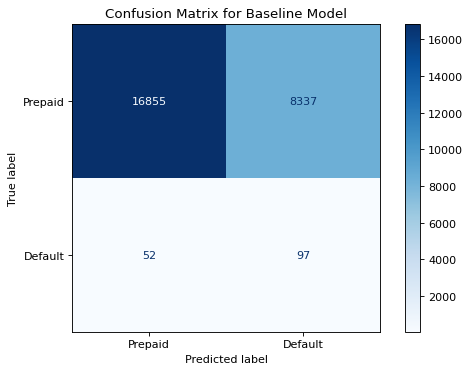

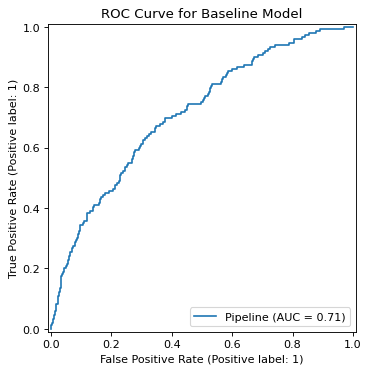

In [159]:
# Define categorical and numerical features
cat_cols = ['flag_fthb', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 'cnt_borr']
num_cols = ['fico_log', 'mi_pct', 'dti', 'ltv', 'int_rt', 'orig_upb', 'loan_age_months']

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='error'), cat_cols)
    ]
)

# Combine preprocessing and model into a pipeline
baseline_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Adjusts weights for imbalance
        max_iter=1000, 
        random_state=42
    ))
])

# Train the model
baseline_model.fit(X_train, y_train)

# Predict on test data
y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]  # Probabilities for default

print(classification_report(y_test, y_pred))
# Evaluate performance
print("Baseline Model Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Prepaid', 'Default'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Baseline Model')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(baseline_model, X_test, y_test)
plt.title('ROC Curve for Baseline Model')
plt.show()

In [160]:
print(y_train.value_counts())

loan_status
0    100767
1       597
Name: count, dtype: int64


## XGBoost

In [161]:
# Define categorical and numerical features (include ALL 20 features)
cat_cols = [
    'flag_fthb', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose',
    'st', 'mi_cancel_ind', 'cnt_borr', 'cnt_units', 
    'property_val', 
    'cd_msa', 'zipcode'
]
code_cols = []
num_cols = [
    'fico', 'fico_log', 'mi_pct', 'dti', 'ltv', 'int_rt', 'orig_upb', 'orig_upb_log',
    'loan_age_months', 'orig_loan_term'
]

# Preprocessing (no scaling needed for tree-based models)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # Pass numerical features unchanged
)

# Convert categorical columns to pandas "category" dtype
X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')
# Transform training data
X_train_processed = preprocessor.fit_transform(X_train)
# Convert sparse output to dense array
X_train_processed = X_train_processed.toarray()
# Convert to pandas DataFrame with proper column names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])
X_train_processed = pd.DataFrame(X_train_processed, columns=all_features)

# Ensure all columns are numeric
X_train_processed = X_train_processed.astype(float)

In [162]:
neg = len(y_train[y_train == 0])
pos = len(y_train[y_train == 1])
scale_pos_weight = neg / pos  # Approx 32:1 for your data
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 168.79


In [163]:
# Define parameter grid
param_grid = {
    'classifier__subsample': [0.95, 1.0], # [0.5, 1.0]
    'classifier__n_estimators': [175, 200, 225, 250], # [50, 2000]
    'classifier__max_depth': [2, 3, 4],  # [1, 20]
    'classifier__learning_rate': [0.075, 0.1, 0.125, 0.15], # [0.01, 0.3]
    'classifier__gamma': [0.07, 0.1, 0.13], # [0, 1]
    'classifier__colsample_bytree': [0.95, 1.0] # [0.5, 1.0]
    }

# Create pipeline
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(sampling_strategy=0.3, random_state=42)),  # Optional: add SMOTE for oversampling
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,  # Adjust for class imbalance
        random_state=42,
        eval_metric='auc'
    ))
])

# RandomizedSearchCV with stratified K-fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    xgb_model,
    param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

# Fit model
search.fit(X_train, y_train)
# Get best parameters without the pipeline prefix
best_params = {k.replace('classifier__', ''): v for k, v in search.best_params_.items()}
# Best parameters
print("Best Parameters:", best_params)

Best Parameters: {'subsample': 1.0, 'n_estimators': 250, 'max_depth': 2, 'learning_rate': 0.15, 'gamma': 0.13, 'colsample_bytree': 1.0}


In [164]:
# Initialize final model with tuned parameters
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        **best_params,
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ))
])

# Train
final_model.fit(X_train, y_train)

c:\Users\zhang\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flag_fthb', 'occpy_sts',
                                                   'channel', 'prop_type',
                                                   'loan_purpose', 'st',
                                                   'mi_cancel_ind', 'cnt_borr',
                                                   'cnt_units', 'property_val',
                                                   'cd_msa', 'zipcode'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None...
                               feature_types=None, gamma=0.13, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=250, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

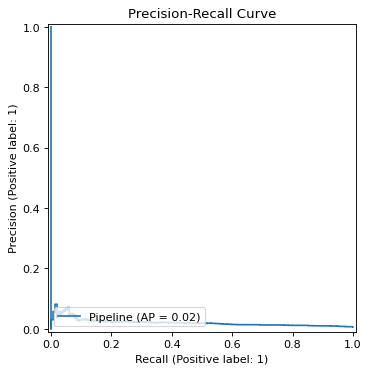

In [165]:
from sklearn.metrics import PrecisionRecallDisplay
# Plot Precision-Recall curve
PrecisionRecallDisplay.from_estimator(final_model, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     25192
           1       0.01      0.66      0.03       149

    accuracy                           0.72     25341
   macro avg       0.51      0.69      0.43     25341
weighted avg       0.99      0.72      0.83     25341

XGBoost Performance:
- Accuracy: 0.72
- Precision: 0.01
- Recall: 0.66
- F1 Score: 0.03
- ROC-AUC: 0.77


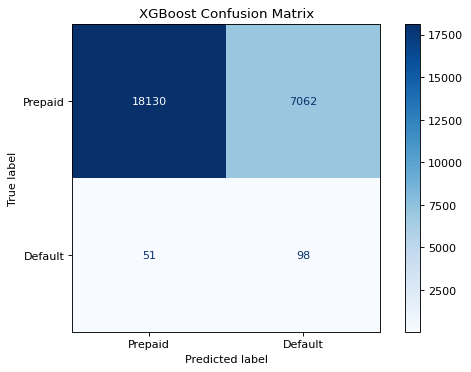

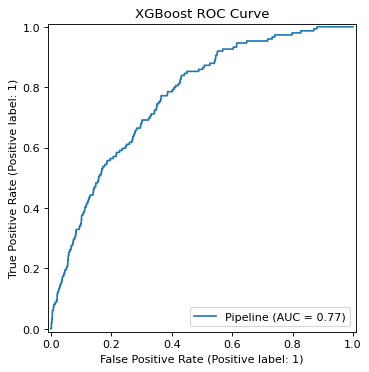

In [166]:
# Predictions
y_pred_xgb = final_model.predict(X_test)
y_proba_xgb = final_model.predict_proba(X_test)[:, 1]

threshold = 0.45  # Adjust based on PR curve analysis
y_pred_xgb = (y_proba_xgb >= threshold).astype(int)
print(classification_report(y_test, y_pred_xgb))
# Performance metrics
print("XGBoost Performance:")
print(f"- Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"- Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"- Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"- F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print(f"- ROC-AUC: {roc_auc_score(y_test, y_proba_xgb):.2f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Prepaid', 'Default'])
disp_xgb.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test)
plt.title('XGBoost ROC Curve')
plt.show()

<Figure size 960x640 with 0 Axes>

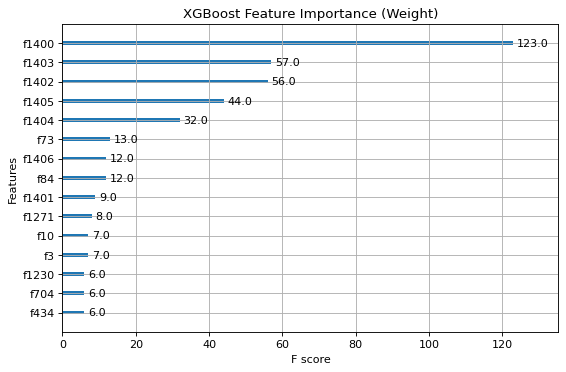

In [167]:
# Extract feature names after one-hot encoding
encoder = final_model.named_steps['preprocessor'].named_transformers_['cat']
cat_features = encoder.get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(
    final_model.named_steps['classifier'], 
    importance_type='weight', 
    max_num_features=15,
    title='XGBoost Feature Importance (Weight)'
)
plt.show()

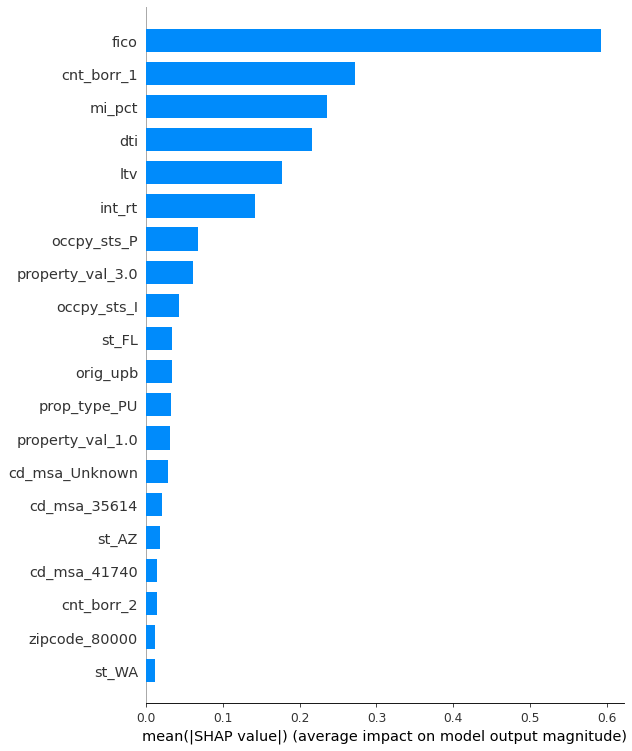

In [168]:
# Get preprocessed data
X_processed = final_model.named_steps['preprocessor'].transform(X_train)

# SHAP summary plot
explainer = shap.TreeExplainer(final_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_processed)
shap.summary_plot(shap_values, X_processed, feature_names=all_features, plot_type='bar')

In [169]:
print("Baseline vs XGBoost Comparison:")
print(f"Metric\t\tBaseline\tXGBoost")
print(f"Accuracy\t{accuracy_score(y_test, y_pred):.2f}\t\t{accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision\t{precision_score(y_test, y_pred):.2f}\t\t{precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall\t\t{recall_score(y_test, y_pred):.2f}\t\t{recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score\t{f1_score(y_test, y_pred):.2f}\t\t{f1_score(y_test, y_pred_xgb):.2f}")
print(f"ROC-AUC\t\t{roc_auc_score(y_test, y_proba):.2f}\t\t{roc_auc_score(y_test, y_proba_xgb):.2f}")

Baseline vs XGBoost Comparison:
Metric		Baseline	XGBoost
Accuracy	0.67		0.72
Precision	0.01		0.01
Recall		0.65		0.66
F1 Score	0.02		0.03
ROC-AUC		0.71		0.77


In [170]:
print(X_train[['fico', 'fico_log']].corr())

              fico  fico_log
fico      1.000000 -0.954393
fico_log -0.954393  1.000000


# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [94]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Support files will be in project2_files\
[NbConvertApp] Making directory .\project2_files
[NbConvertApp] Writing 110035 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 646095 bytes to project2.pdf
